I realize this is very messy. I want to keep trying other things while the code is running in another notebook

In [1]:
import pandas as pd

In [2]:
df = pd.read_parquet('../../shared_data/X_test.parquet')

In [3]:
df['text']

156994    Sugar, partially hydrogenated vegetable shorte...
117668    Beef bites (beef, salt, contains 2% or less of...
47339     Nonfat dry milk, vitamin a palmitate, vitamin d3.
111892                        Cultured milk, salt, enzymes.
90140     Apples, high fructose corn syrup, water, ascor...
                                ...                        
54326     Milk chocolate (sugar, cocoa butter, chocolate...
167134    Unbleached enriched wheat flour (niacin, reduc...
13046     Peanuts, sugar, butter* (cream [milk], salt), ...
94447     Water, sugar, corn syrup, citric acid, guar gu...
117507    Caramel ice cream: cream, skim milk, sugar, eg...
Name: text, Length: 40879, dtype: object

In [4]:
lengths = []

for row in df['text']:
    lengths.append(len(row))

len(lengths)

40879

In [5]:
sum(lengths) / len(lengths)

389.7389368624477

So we should use 512 max_length

Let's standardize the 'y'

In [6]:
df = pd.read_parquet('../../shared_data/df.parquet')

In [7]:
df.y.values

array([27., 39., 41., ..., 42., 50., 60.])

<Axes: >

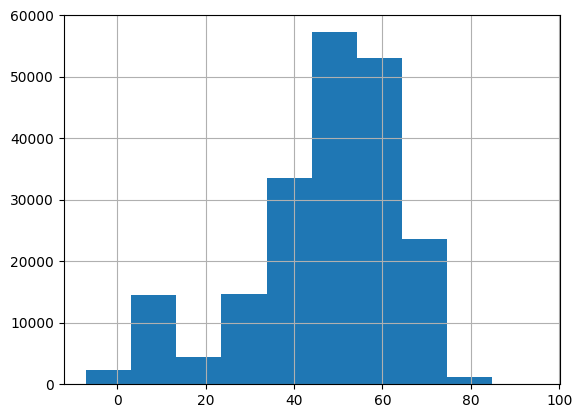

In [9]:
df.y.hist()

# Resuming from xgboost - lfs is broken #

In [1]:
import pickle

with open('../../shared_data/X_train_final_df.pkl', 'rb') as file:
    X_train_final_df = pickle.load(file)

with open('../../shared_data/X_test_final_df.pkl', 'rb') as file:
    X_test_final_df = pickle.load(file)

with open('../../shared_data/y_train_final.pkl', 'rb') as file:
    y_train_final = pickle.load(file)

with open('../../shared_data/y_test_final.pkl', 'rb') as file:
    y_test_final = pickle.load(file)

Let's hyperparamaterize our ExtraTreeRegressor

In [2]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import ExtraTreeRegressor

In [9]:
param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': ['auto', 'sqrt', 'log2', 0.5, 0.8],
    'min_impurity_decrease': [0.0, 0.01, 0.1],
    'criterion': ['squared_error', 'poisson']
}

In [10]:
random_search = RandomizedSearchCV(ExtraTreeRegressor(), param_distributions=param_grid, n_iter=500, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train_final_df, y_train_final)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] END criterion=poisson, max_depth=30, max_features=log2, min_impurity_decrease=0.01, min_samples_leaf=2, min_samples_split=5; total time=   1.4s
[CV] END criterion=poisson, max_depth=30, max_features=log2, min_impurity_decrease=0.01, min_samples_leaf=2, min_samples_split=5; total time=   1.6s
[CV] END criterion=poisson, max_depth=30, max_features=log2, min_impurity_decrease=0.01, min_samples_leaf=2, min_samples_split=5; total time=   1.9s
[CV] END criterion=poisson, max_depth=30, max_features=log2, min_impurity_decrease=0.01, min_samples_leaf=2, min_samples_split=5; total time=   1.4s
[CV] END criterion=poisson, max_depth=30, max_features=log2, min_impurity_decrease=0.01, min_samples_leaf=2, min_samples_split=5; total time=   1.4s
[CV] END criterion=poisson, max_depth=30, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=10; total time=   2.0s
[CV] END criterion=squared_error, max_dept

/Users/michaelwales/.pyenv/versions/3.10.6/envs/smartfoodscan/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
495 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
362 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelwales/.pyenv/versions/3.10.6/envs/smartfoodscan/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/michaelwales/.pyenv/versions/3.10.6/envs/smartfoodscan/lib/python3.10/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Users/michaelwales/.pyenv/ver

RandomizedSearchCV(cv=5, estimator=ExtraTreeRegressor(), n_iter=500, n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'poisson'],
                                        'max_depth': [None, 10, 20, 30, 40],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         0.5, 0.8],
                                        'min_impurity_decrease': [0.0, 0.01,
                                                                  0.1],
                                        'min_samples_leaf': [1, 2, 4, 10],
                                        'min_samples_split': [2, 5, 10, 20]},
                   random_state=42, verbose=2)

In [11]:
random_search.best_params_

{'min_samples_split': 20,
 'min_samples_leaf': 4,
 'min_impurity_decrease': 0.0,
 'max_features': 0.8,
 'max_depth': None,
 'criterion': 'squared_error'}

In [12]:
random_search.best_score_

0.8753464140465367

In [13]:
best_model = random_search.best_estimator_
best_model.score(X_test_final_df, y_test_final)

0.8818928202719009